# Import Data

In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12 
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [44]:
import sys
import pickle
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...


  2%|▏         | 3/141 [00:00<00:06, 20.04it/s]

Finished loading INFO


100%|██████████| 141/141 [00:31<00:00,  4.41it/s]


In [5]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']
cluster = Data.data_obj['cluster']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

with open (f"{PROJECT_PATH_BMGPU}/{config['result_path']}/limb_scale_model.pickle", 'rb') as file:
    limb_scaler = pickle.load(file)

/Users/donghur/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
caste_idx = {"min": [], "mid": [], "maj":[]}
env_idx = {"food": [], "free":[]}

# cluster = full_label
for item in INFO_values:
    path = item['directory']
    start, stop = item['global_start_fr'], item['global_stop_fr']

    # Caste Condition
    if path.find("min") is not -1:
        caste_idx["min"].extend(list(range(start,stop)))
    if path.find("mid") is not -1:
        caste_idx["mid"].extend(list(range(start,stop)))
    if path.find("maj") is not -1:
        caste_idx["maj"].extend(list(range(start,stop)))
    
    # Environmental Conditionse
    if path.find("fd") is not -1:
        env_idx["food"].extend(list(range(start,stop)))
    if path.find("fr") is not -1:
        env_idx["free"].extend(list(range(start,stop)))


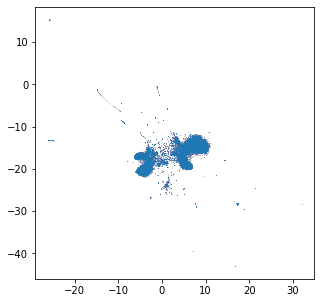

In [24]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
plt.show()

# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

# Analysis 1

Description: See if the antennal shape differs when walking vs running

In [37]:
# find the index of where the ants are walking fast
for i, label in enumerate(config['angle_labels']):
    print(f"{i} -  {label}")

0 -  Head
1 -  Abdomen
2 -  (R) Antennae
3 -  (R) Antennae 2
4 -  (R) Front Leg
5 -  (R) Mid Leg
6 -  (R) Hind Leg
7 -  (L) Antennae
8 -  (L) Antennae 2
9 -  (L) Front Leg
10 -  (L) Mid Leg
11 -  (L) Hind Leg


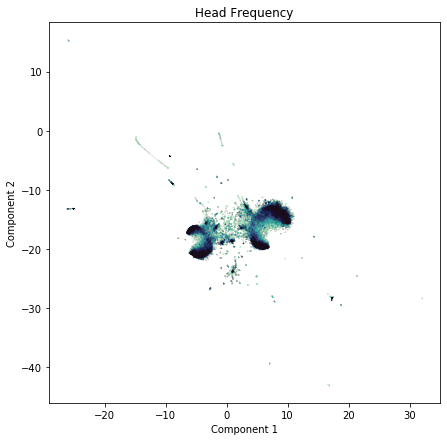

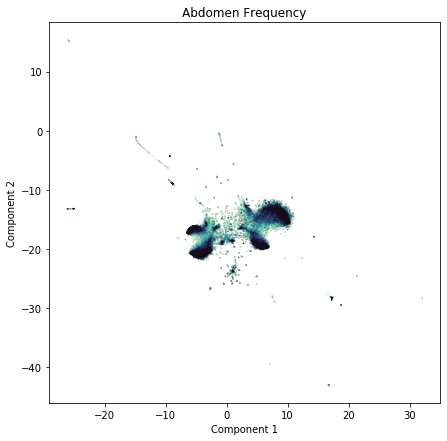

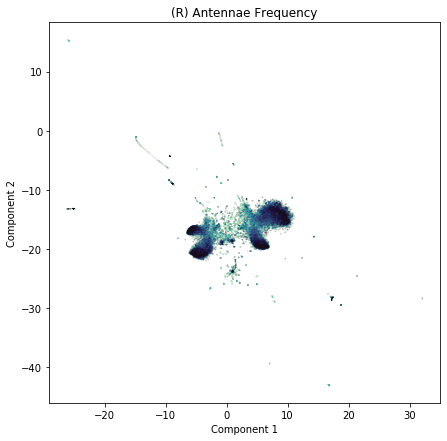

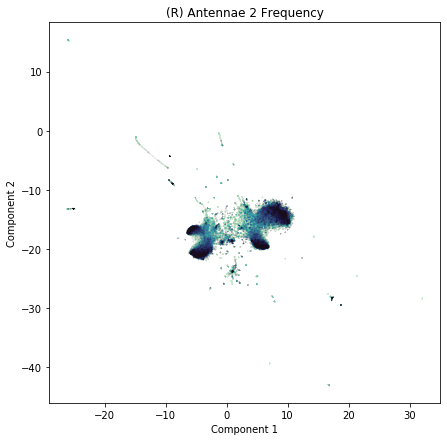

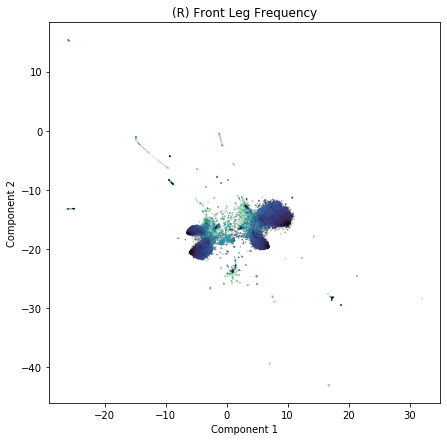

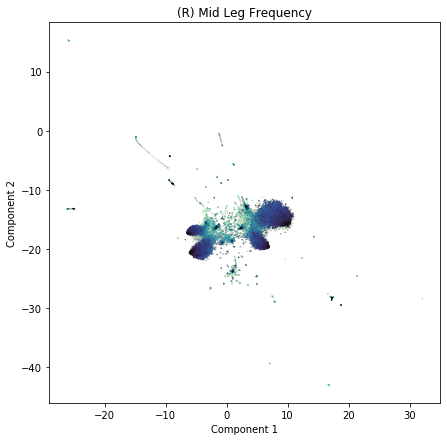

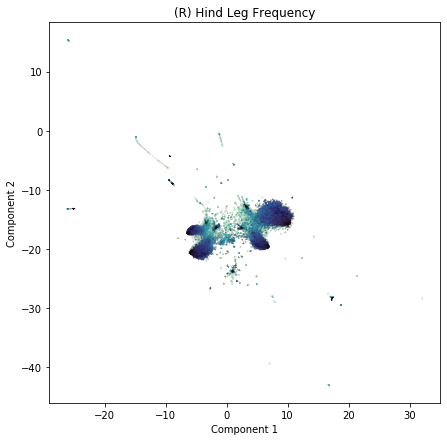

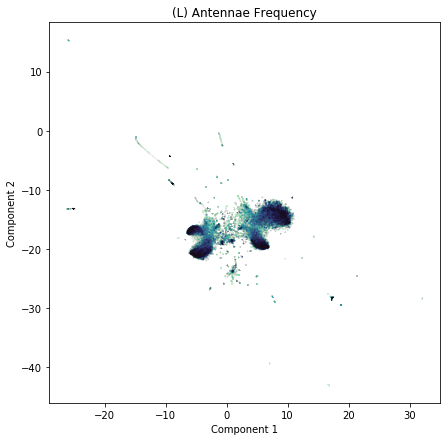

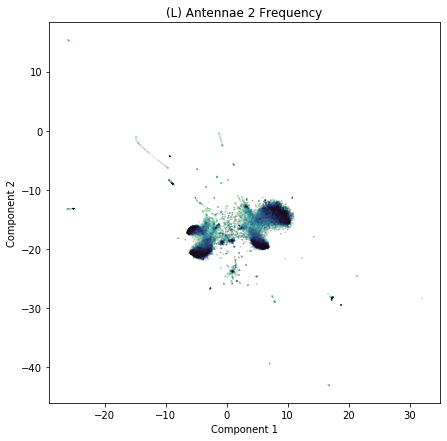

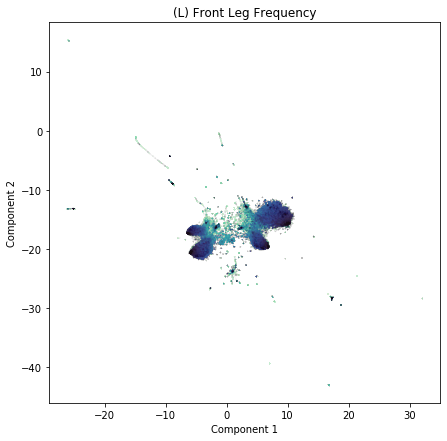

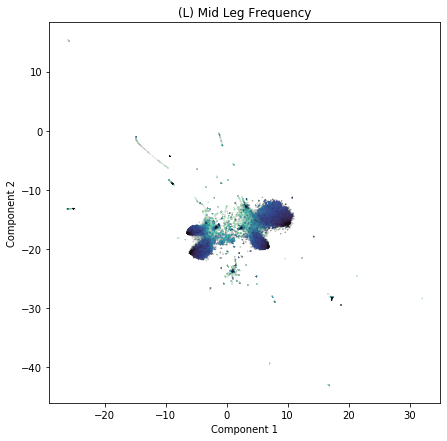

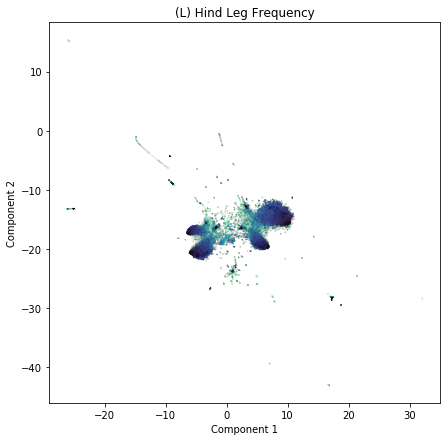

In [51]:
max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] # Nyquist Frequency
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1)) # dyadic frequency bins

# Figure Information
max_freq_idx = np.argmax(angle_power[:,:,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = matplotlib.colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures

for angle_idx in tqdm(range(12)):
    fig, ax = plt.subplots(figsize=(7,7))
    fig_title = f"{config['angle_labels'][angle_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[:,angle_idx]])

    ax.scatter(all_embed[:,0], all_embed[:,1], color=freq_cluster_colors, alpha=0.005, s=1.5)  
    ax.set(xlabel='Component 1', ylabel='Component 2', title=fig_title) # xlim=region_x_lim, ylim=region_y_lim

plt.show()

In [52]:
max_freq_idx.shape

(1872138, 12)

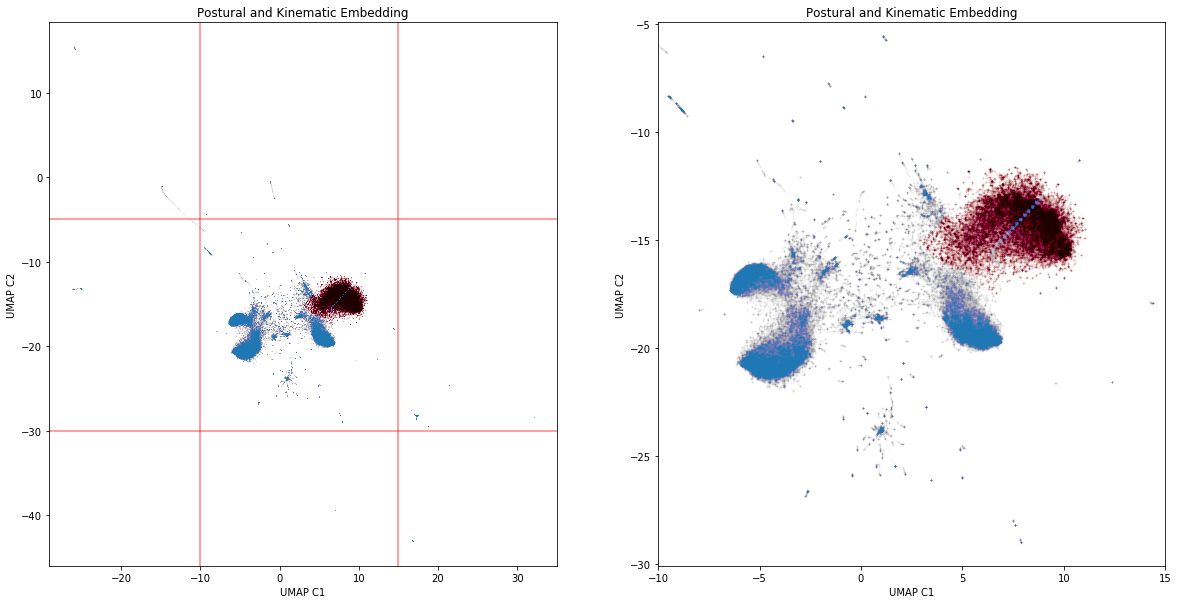

In [34]:
region_x_lim, region_y_lim = (-10,15), (-30,-5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
ax[0].scatter(all_embed[clust_55_56_idx,0], all_embed[clust_55_56_idx,1], s=1, alpha=0.005, c='r')
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_embed[:,0], all_embed[:,1], s=1.5, alpha=0.002)
ax[1].scatter(all_embed[clust_55_56_idx,0], all_embed[clust_55_56_idx,1], s=1.5, alpha=0.002, c='r')
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

# Analysis 2: Major & Minor Difference in Behavioral Distribution

Description: Subtracting the Minor and Major ant density plot to see differences in distribution of behaviors displayed.

* need to be careful of the different number of frames that exist for each caste